In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
#matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Import The Dataset

In [ ]:
file_path = '/content/drive/MyDrive/Machine Learning/Explored_data.csv'
df = pd.read_csv(file_path)
df.head()

,age,income,home_ownership_type,years_of_employment,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,default_history,cb_person_cred_hist_length,loan_status,person_age_sqrt,loan_percent_income_sqrt
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,4.582576,0.316228
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,5.000000,0.754983
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,4.795832,0.728011
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,4.898979,0.741620
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,4.582576,0.500000


In [ ]:
df.drop(['person_age_sqrt', 'loan_percent_income_sqrt'], inplace=True, axis=1)

In [ ]:
credit_df = df.copy()

## Split the Data into Training, Validation and Test sets

In [ ]:
X = credit_df.drop('loan_status', axis=1)
y = credit_df['loan_status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
print(X_train.shape)
print(y_train.shape)
y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

(18912, 11)
(18912,)


,proportion
loan_status,
0,78.41%
1,21.59%


#### Dealing with Imabalanced Data
From the **Credi Risk EDA** file, the data was found to be imbalanced. To manage this issue, `SMOTE` will be used for **UnderSampling**

#### 1) OverSampling
Oversampling involves oversampling the minority class with replacement. The goal is to generate enough of the minority class to
have adequate representation during training of the model

#### 2) UnderSampling
This involves taking a smaller sample of the majority class to use for training the model.

#### 3) Synthetic Minority Oversampling Technique(SMOTE)
This is like oversampling, except with SMOTE, new instances of the minority class are synthesized based on the existing data.


## UnderSampling The data

In [ ]:
# Apply random undersampling to the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

under_sampled_set = pd.concat([X_train_resampled, y_train_resampled], axis=1)
under_sampled_set.head()

,age,income,home_ownership_type,years_of_employment,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,default_history,cb_person_cred_hist_length,loan_status
552,26,97000,RENT,3.0,EDUCATION,C,21000,NaN,0.22,Y,3,0
31209,38,67870,MORTGAGE,6.0,MEDICAL,B,5000,NaN,0.07,N,13,0
2765,26,35000,MORTGAGE,3.0,PERSONAL,B,7200,10.59,0.21,N,3,0
14030,24,107203,MORTGAGE,8.0,PERSONAL,A,6000,7.40,0.06,N,2,0
4478,26,107000,RENT,2.0,MEDICAL,A,9800,8.90,0.09,N,3,0


In [ ]:
under_sampled_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8168 entries, 552 to 1164
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         8168 non-null   int64  
 1   income                      8168 non-null   int64  
 2   home_ownership_type         8168 non-null   object 
 3   years_of_employment         8168 non-null   float64
 4   loan_intent                 8168 non-null   object 
 5   loan_grade                  8168 non-null   object 
 6   loan_amnt                   8168 non-null   int64  
 7   loan_int_rate               7402 non-null   float64
 8   loan_percent_income         8168 non-null   float64
 9   default_history             8168 non-null   object 
 10  cb_person_cred_hist_length  8168 non-null   int64  
 11  loan_status                 8168 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 829.6+ KB


Distribution of the Classes in the subsample dataset
loan_status
0    0.5
1    0.5
Name: count, dtype: float64


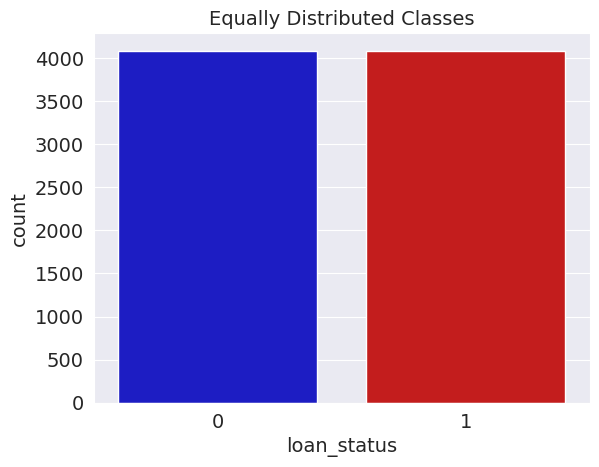

In [ ]:
colors = ["#0101DF", "#DF0101"]

# Print the distribution of classes
print('Distribution of the Classes in the subsample dataset')
print(under_sampled_set['loan_status'].value_counts() / len(under_sampled_set))

# Create a countplot with the hue parameter set to the same as x
sns.countplot(x='loan_status', hue='loan_status', data=under_sampled_set, palette=colors, legend=False)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [ ]:
under_sampled_set['loan_status'].value_counts()

,count
loan_status,
0,4084
1,4084


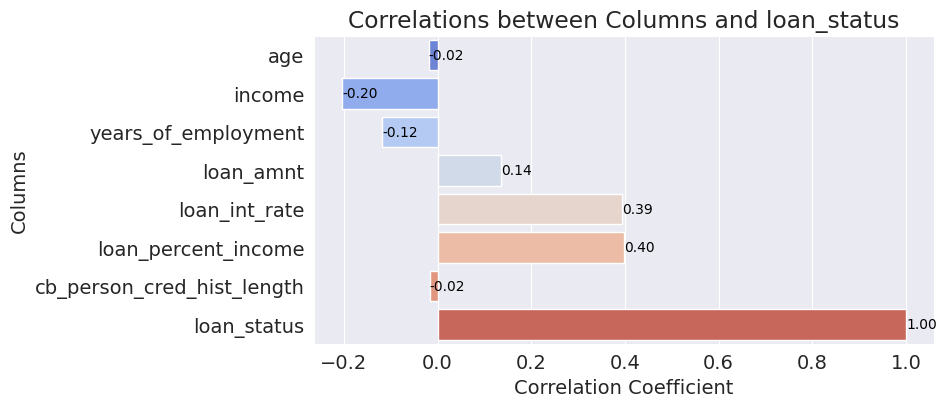

In [ ]:
target_column = 'loan_status'

# Calculate correlations between numeric columns and the target variable
numeric_columns = under_sampled_set.select_dtypes(include=['int64', 'float64']).columns
correlations = under_sampled_set[numeric_columns].corrwith(under_sampled_set[target_column])

# Create a horizontal bar chart with labels
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=correlations, y=correlations.index, hue=correlations.index,  palette='coolwarm', legend=False)

# Add values as labels on the bars
for i, value in enumerate(correlations):
    ax.text(value, i, f'{value:.2f}', va='center', fontsize=10, color='black')

plt.title(f'Correlations between Columns and {target_column}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Columns')
plt.show()

In [ ]:
numeric_cols = credit_df.columns[credit_df.nunique() > 7].tolist()
numeric_cols.remove('loan_percent_income')
numeric_cols

['age',
 'income',
 'years_of_employment',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

In [ ]:
categorical_cols = credit_df.columns[credit_df.nunique() <= 7].tolist()
categorical_cols.remove('loan_status')
categorical_cols

['home_ownership_type', 'loan_intent', 'loan_grade', 'default_history']

In [ ]:
X_under = under_sampled_set.drop('loan_status', axis=1)
y_under = under_sampled_set['loan_status']

In [ ]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting needed
        return self

    def transform(self, X):
        # Ensure X is a DataFrame, converting from NumPy array if necessary
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        # Apply Box-Cox transformation
        transformed = []
        for col in X.columns:
            # Handle non-positive values
            if (X[col] <= 0).any():
                # Use Yeo-Johnson for data that includes negative values or zeros
                transformed_col, _ = stats.yeojohnson(X[col])
            else:
                # Apply Box-Cox directly if all values are positive
                transformed_col, _ = stats.boxcox(X[col])
            transformed.append(transformed_col)

        return pd.DataFrame(np.array(transformed).T, columns=X.columns)

# Split your features into categorical and numerical columns
X_categorical = X_under[categorical_cols]
X_numerical = X_under[numeric_cols]

# Define the transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # In case future data has missing values
    ('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with median
    ('boxcox', BoxCoxTransformer()),  # Custom transformer for Box-Cox
    ('scaler', RobustScaler())  # Normalize using RobustScaler
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numeric_cols)
    ],
    remainder='passthrough'  # Keep any other columns
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit data
pipeline.fit(X_under)

# Transform the data
X_transformed_under = pipeline.transform(X_under)

# Handling feature names
# Get feature names for categorical columns using OneHotEncoder
cat_features = pipeline.named_steps['preprocessor'].transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Use original numerical column names and include 'loan_percent_income'
num_features = numeric_cols + ['loan_percent_income']  # Ensure loan_percent_income is included

# Combine all feature names
all_features = np.hstack([cat_features, num_features])

# Create DataFrame from transformed data
X_transformed_under_df = pd.DataFrame(X_transformed_under, columns=all_features)
X_transformed_under_df.head()

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.000000,0.863348,-0.222293,0.980084,0.000000,-0.325328,0.22
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.932728,0.402359,0.357705,-0.493316,0.000000,1.068163,0.07
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,-0.479424,-0.222293,-0.169348,-0.287416,-0.325328,0.21
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.335667,0.990670,0.643686,-0.335172,-1.051404,-0.835861,0.06
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.988264,-0.492420,0.129581,-0.687222,-0.325328,0.09


## Model Training using UnderSampled Data

In [ ]:
y_under.values

array([0, 0, 0, ..., 1, 1, 1])

Classifier: DecisionTreeClassifier has a training score of 79.84% accuracy



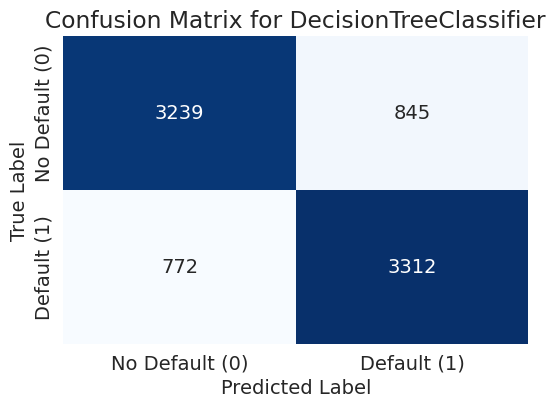


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

  No Default       0.81      0.79      0.80      4084
     Default       0.80      0.81      0.80      4084

    accuracy                           0.80      8168
   macro avg       0.80      0.80      0.80      8168
weighted avg       0.80      0.80      0.80      8168

Precision: 0.80, Recall: 0.81, F1 Score: 0.80


Classifier: RandomForestClassifier has a training score of 85.2% accuracy



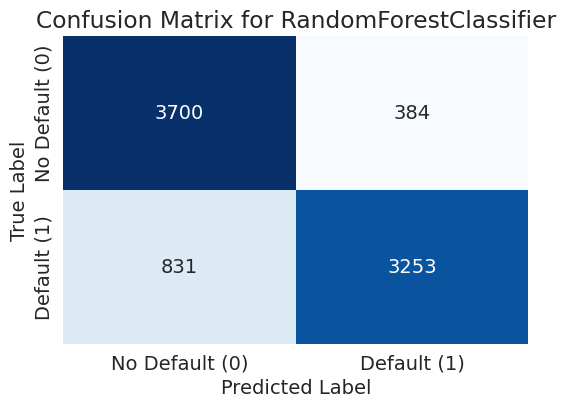


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

  No Default       0.82      0.91      0.86      4084
     Default       0.89      0.80      0.84      4084

    accuracy                           0.85      8168
   macro avg       0.86      0.85      0.85      8168
weighted avg       0.86      0.85      0.85      8168

Precision: 0.89, Recall: 0.80, F1 Score: 0.84


Classifier: XGBClassifier has a training score of 86.3% accuracy



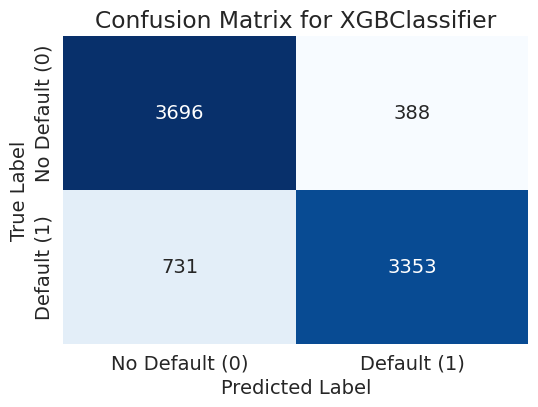


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

  No Default       0.83      0.90      0.87      4084
     Default       0.90      0.82      0.86      4084

    accuracy                           0.86      8168
   macro avg       0.87      0.86      0.86      8168
weighted avg       0.87      0.86      0.86      8168

Precision: 0.90, Recall: 0.82, F1 Score: 0.86




In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score


# Define your classifiers (including DecisionTree, RandomForest, and XGBoost)
classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoostClassifier": xgb.XGBClassifier()
}


def plot_confusion_matrix(y_true, y_pred, classifier_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Train the classifiers and evaluate them using confusion matrix, precision, recall, and F1 score
for key, classifier in classifiers.items():
    # Train the model
    classifier.fit(X_transformed_under, y_under.values)

    # Perform cross-validation predictions for the confusion matrix and metrics
    y_pred = cross_val_predict(classifier, X_transformed_under, y_under.values, cv=5)

    # Calculate the training score (cross-validation accuracy)
    training_score = cross_val_score(classifier, X_transformed_under, y_under.values, cv=5)
    print(f"Classifier: {classifier.__class__.__name__} has a training score of {round(training_score.mean() * 100, 2)}% accuracy\n")

    # Plot the confusion matrix using Seaborn
    plot_confusion_matrix(y_under.values, y_pred, classifier.__class__.__name__)

    # Classification report: includes precision, recall, F1-score, and support
    print(f"\nClassification Report for {classifier.__class__.__name__}:")
    print(classification_report(y_under.values, y_pred, target_names=['No Default', 'Default']))

    # Print precision, recall, and F1-score for the Default (1) class
    precision = precision_score(y_under.values, y_pred)
    recall = recall_score(y_under.values, y_pred)
    f1 = f1_score(y_under.values, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("\n" + "="*50 + "\n")

## Grid Search Cross Validation

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

classifiers_param_grids = {
    "DecisionTreeClassifier": (DecisionTreeClassifier(), param_grid_dt),
    "RandomForestClassifier": (RandomForestClassifier(), param_grid_rf),
    "XGBoostClassifier": (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Loop through each classifier and run GridSearchCV
for classifier_name, (classifier, param_grid) in classifiers_param_grids.items():
    print(f"Performing Grid Search for {classifier_name}...")

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_transformed_under, y_under.values)

    # Print the best parameters and the best score
    print(f"Best parameters for {classifier_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {classifier_name}: {round(grid_search.best_score_ * 100, 2)}%\n")



Performing Grid Search for DecisionTreeClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best cross-validation score for DecisionTreeClassifier: 83.8%

Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score for RandomForestClassifier: 85.36%

Performing Grid Search for XGBoostClassifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for XGBoostClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score for XGBoostClassifier: 86.57%



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
X_val

,age,income,home_ownership_type,years_of_employment,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,default_history,cb_person_cred_hist_length
14758,23,113000,MORTGAGE,6.0,DEBTCONSOLIDATION,B,10000,10.38,0.09,N,3
30108,38,35000,RENT,22.0,EDUCATION,A,11100,6.62,0.32,N,14
23929,27,75000,OWN,0.0,HOMEIMPROVEMENT,A,7500,8.38,0.10,N,6
27010,31,50402,MORTGAGE,4.0,VENTURE,C,3000,13.22,0.06,Y,10
14533,23,120000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,15000,NaN,0.13,N,4
...,...,...,...,...,...,...,...,...,...,...,...
27315,29,35000,OWN,11.0,MEDICAL,C,4200,12.99,0.12,N,8
12510,26,78000,RENT,4.0,DEBTCONSOLIDATION,A,12000,7.14,0.15,N,2
278,23,15000,OWN,4.0,DEBTCONSOLIDATION,C,4000,13.98,0.27,N,4
27108,27,82000,MORTGAGE,11.0,VENTURE,A,10000,7.51,0.12,N,6


In [22]:
X_transformed_val = pipeline.transform(X_val)
X_transformed_val

array([[ 0.        ,  0.        ,  0.        , ..., -0.83992793,
        -0.30044975,  0.09      ],
       [ 0.        ,  0.        ,  1.        , ..., -1.49741504,
         1.23091527,  0.32      ],
       [ 0.        ,  1.        ,  0.        , ..., -1.17874043,
         0.47014433,  0.1       ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.27518653,
         0.03750976,  0.27      ],
       [ 0.        ,  0.        ,  0.        , ..., -1.33348695,
         0.47014433,  0.12      ],
       [ 0.        ,  0.        ,  1.        , ..., -0.44876092,
         0.03750976,  0.29      ]])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[4394  548]
 [ 390  972]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4942
           1       0.64      0.71      0.67      1362

    accuracy                           0.85      6304
   macro avg       0.78      0.80      0.79      6304
weighted avg       0.86      0.85      0.85      6304

Precision: 0.64, Recall: 0.71, F1 Score: 0.67


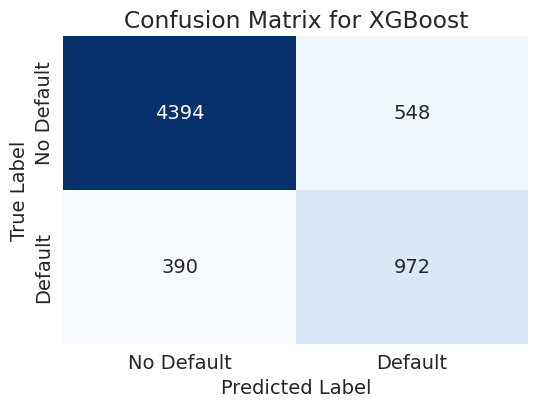

In [23]:
# Best parameters for XGBoost from your Grid Search
best_params_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.2,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 1.0,
}

# Initialize XGBoost with the best parameters
xgb_model = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data (if you haven't done this already)
xgb_model.fit(X_transformed_under, y_under.values)

# Predict on the validation data
y_val_pred = xgb_model.predict(X_transformed_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val.values, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val.values, y_val_pred))

# Calculate precision, recall, and F1 score
precision = precision_score(y_val.values, y_val_pred)
recall = recall_score(y_val.values, y_val_pred)
f1 = f1_score(y_val.values, y_val_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    plt.title("Confusion Matrix for XGBoost")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix)


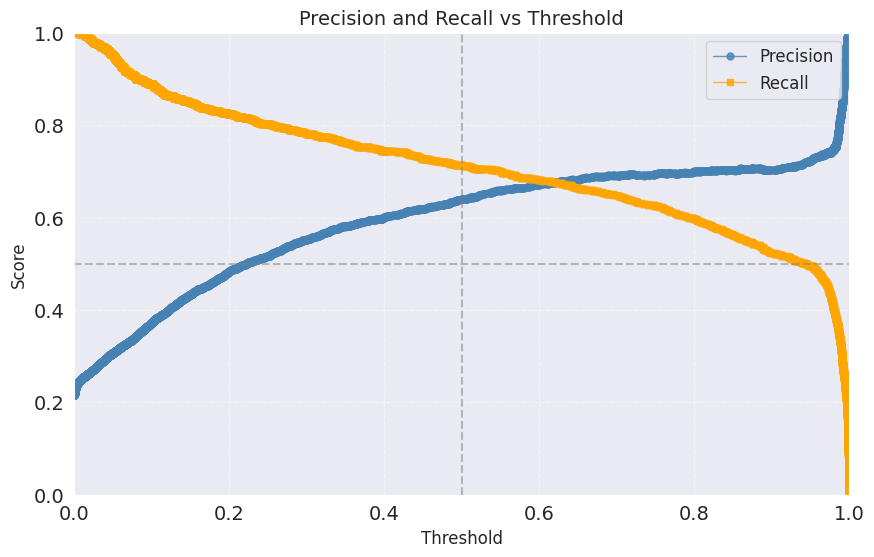

In [24]:
from sklearn.metrics import precision_recall_curve

y_scores = xgb_model.predict_proba(X_transformed_val)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(thresholds, precision[:-1], marker='o', color='steelblue', markersize=5, linewidth=1, alpha=0.8, label='Precision')
plt.plot(thresholds, recall[:-1], marker='s', color='orange', markersize=5, linewidth=1, alpha=0.8, label='Recall')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.grid(linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=12)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Adjusting Threshold

In [29]:
def plot_metrics_and_confusion_matrix(model, X_val, y_val, start=0.1, stop=0.9, step=0.05, specific_threshold=None):
    # Get predicted probabilities for the positive class (1)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Define a range of threshold values
    thresholds = np.arange(start, stop, step)

    # Initialize lists to store precision and recall scores at each threshold
    precision_scores = []
    recall_scores = []

    # Loop through each threshold to calculate scores
    for threshold in thresholds:
        # Get binary predictions based on the threshold
        y_val_pred_threshold = (y_val_proba >= threshold).astype(int)

        # Calculate precision and recall
        precision = precision_score(y_val, y_val_pred_threshold)
        recall = recall_score(y_val, y_val_pred_threshold)

        # Append scores to lists
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Plot Precision and Recall vs Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision', marker='o', color='blue')
    plt.plot(thresholds, recall_scores, label='Recall', marker='o', color='green')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()  # Separate the precision/recall plot from the confusion matrix plot

    # Show performance metrics and confusion matrix for specific threshold
    if specific_threshold is not None:
        y_val_pred_specific = (y_val_proba >= specific_threshold).astype(int)

        # Calculate metrics
        precision = precision_score(y_val, y_val_pred_specific)
        recall = recall_score(y_val, y_val_pred_specific)
        f1 = f1_score(y_val, y_val_pred_specific)

        print(f"\nPerformance metrics at threshold {specific_threshold}:")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_val_pred_specific))

        # Display confusion matrix
        conf_matrix = confusion_matrix(y_val, y_val_pred_specific)
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
        plt.title(f"Confusion Matrix at Threshold = {specific_threshold}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()  # Separate the confusion matrix plot



Performance metrics at threshold 0.5:
Precision: 0.64
Recall: 0.71
F1 Score: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4942
           1       0.64      0.71      0.67      1362

    accuracy                           0.85      6304
   macro avg       0.78      0.80      0.79      6304
weighted avg       0.86      0.85      0.85      6304



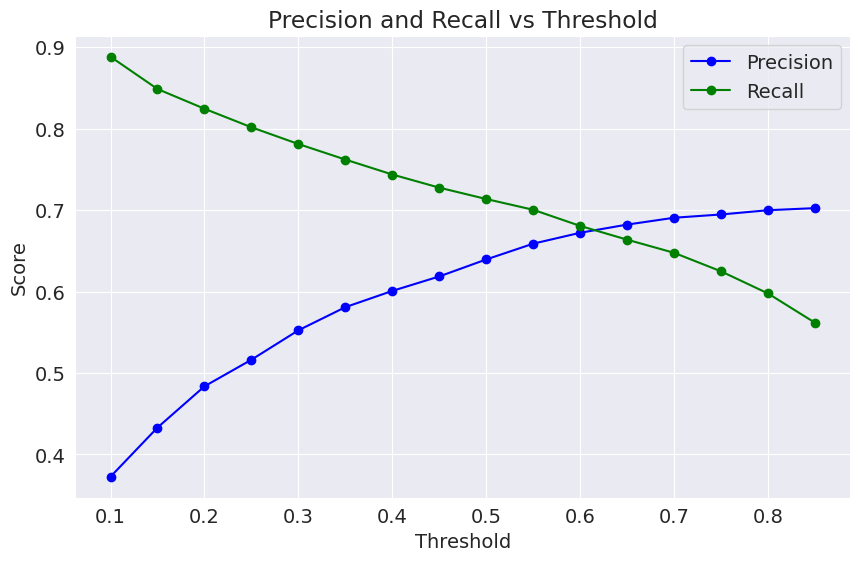

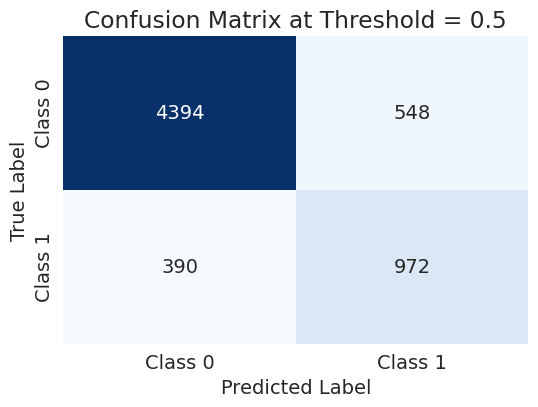

In [28]:
plot_metrics_and_confusion_matrix(xgb_model, X_transformed_val, y_val.values, specific_threshold=0.50)

## Using The Model

In [30]:
def predict_with_threshold(model, X, threshold=0.5):
    # Get probability of the positive class (assuming binary classification)
    probabilities = model.predict_proba(X)[:, 1]
    # Apply threshold to get binary predictions
    predictions = (probabilities >= threshold).astype(int)
    return predictions

## Save Model

In [31]:
import joblib
import os

base_path = '/content/drive/My Drive/Machine Learning/models'
os.makedirs(base_path, exist_ok=True)


model_path = os.path.join(base_path, 'xgboost_model1.pkl')
joblib.dump(xgb_model, model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/Machine Learning/models/xgboost_model1.pkl


## Using Smote for OverSampling

In [ ]:
# Custom transformer for Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting needed
        return self

    def transform(self, X):
        # Ensure X is a DataFrame, converting from NumPy array if necessary
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        # Apply Box-Cox transformation
        transformed = []
        for col in X.columns:
            # Handle non-positive values
            if (X[col] <= 0).any():
                # Use Yeo-Johnson for data that includes negative values or zeros
                transformed_col, _ = stats.yeojohnson(X[col])
            else:
                # Apply Box-Cox directly if all values are positive
                transformed_col, _ = stats.boxcox(X[col])
            transformed.append(transformed_col)

        return pd.DataFrame(np.array(transformed).T, columns=X.columns)

# Split your features into categorical and numerical columns
X_categorical = X_train[categorical_cols]
X_numerical = X_train[numeric_cols]

# Define the transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # In case future data has missing values
    ('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with median
    ('boxcox', BoxCoxTransformer()),  # Custom transformer for Box-Cox
    ('scaler', RobustScaler())  # Normalize using RobustScaler
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numeric_cols)
    ],
    remainder='passthrough'  # Keep any other columns
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit data
pipeline.fit(X_train)

# Transform the data
X_Smote = pipeline.transform(X_train)

# Handling feature names
# Get feature names for categorical columns using OneHotEncoder
cat_features = pipeline.named_steps['preprocessor'].transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Use original numerical column names and include 'loan_percent_income'
num_features = numeric_cols + ['loan_percent_income']  # Ensure loan_percent_income is included

# Combine all feature names
all_features = np.hstack([cat_features, num_features])

# Create DataFrame from transformed data
X_Smote_df = pd.DataFrame(X_Smote, columns=all_features)
X_Smote_df.head()

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.257227,1.016653,0.512118,-0.535221,-0.469875,0.412267,0.04
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.061257,-0.899000,-0.221386,-0.915232,0.023229,-0.322924,0.11
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.227189,0.835674,1.306508,0.535043,-0.373939,0.945870,0.12
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.541498,0.000000,-0.221386,-0.331380,0.701371,-0.825666,0.10
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,-0.949120,-0.830145,0.390596,0.023229,0.000000,0.39


In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_Smote_df, y_train)

In [ ]:
smote_df = pd.concat([X_resampled_smote, y_resampled_smote], axis=1)
smote_df.head()

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income,loan_status
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.257227,1.016653,0.512118,-0.535221,-0.469875,0.412267,0.04,0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-1.061257,-0.899000,-0.221386,-0.915232,0.023229,-0.322924,0.11,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.227189,0.835674,1.306508,0.535043,-0.373939,0.945870,0.12,0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.541498,0.000000,-0.221386,-0.331380,0.701371,-0.825666,0.10,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,-0.949120,-0.830145,0.390596,0.023229,0.000000,0.39,1


In [ ]:
X_resampled_smote

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.257227,1.016653,0.512118,-0.535221,-0.469875,0.412267,0.040000
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.061257,-0.899000,-0.221386,-0.915232,0.023229,-0.322924,0.110000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.227189,0.835674,1.306508,0.535043,-0.373939,0.945870,0.120000
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.541498,0.000000,-0.221386,-0.331380,0.701371,-0.825666,0.100000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,-0.949120,-0.830145,0.390596,0.023229,0.000000,0.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29651,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.705276,-0.064324,-0.611778,1.143297,0.257737,1.005451,0.378462
29652,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.541498,-1.060998,-1.335375,0.255458,-0.210146,-0.091202,0.374582
29653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.541498,-0.279476,0.443542,-0.470037,0.810325,-0.390244,0.113391
29654,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.458502,-0.234984,1.200069,0.434763,-0.483794,0.518114,0.257981


In [ ]:
 y_resampled_smote

,loan_status
0,0
1,0
2,0
3,0
4,1
...,...
29651,1
29652,1
29653,1
29654,1


Distribution of the Classes in the subsample dataset
loan_status
0    0.5
1    0.5
Name: count, dtype: float64


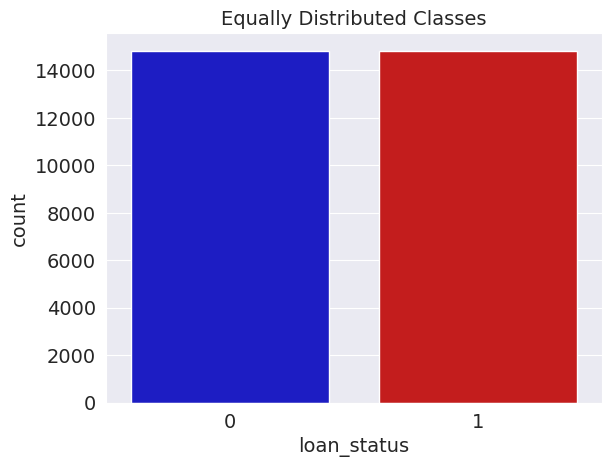

In [ ]:
colors = ["#0101DF", "#DF0101"]
print('Distribution of the Classes in the subsample dataset')
print(smote_df['loan_status'].value_counts()/len(smote_df))

sns.countplot(x='loan_status', hue='loan_status', data=smote_df, palette=colors, legend=False)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Model Training Using OverSampled Data

Classifier: DecisionTreeClassifier has a training score of 89.55% accuracy



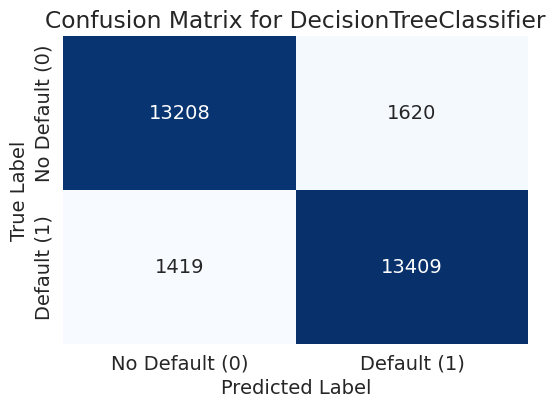


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

  No Default       0.90      0.89      0.90     14828
     Default       0.89      0.90      0.90     14828

    accuracy                           0.90     29656
   macro avg       0.90      0.90      0.90     29656
weighted avg       0.90      0.90      0.90     29656

Precision: 0.89, Recall: 0.90, F1 Score: 0.90


Classifier: RandomForestClassifier has a training score of 94.42% accuracy



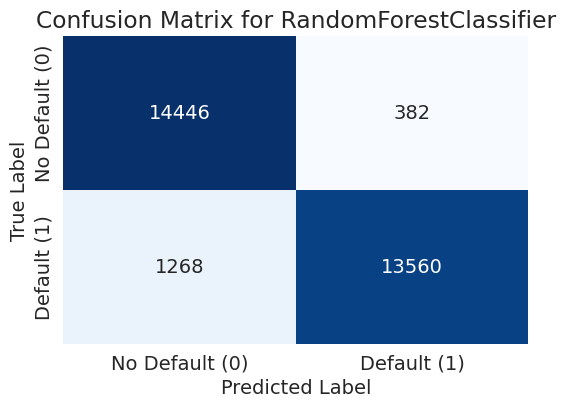


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

  No Default       0.92      0.97      0.95     14828
     Default       0.97      0.91      0.94     14828

    accuracy                           0.94     29656
   macro avg       0.95      0.94      0.94     29656
weighted avg       0.95      0.94      0.94     29656

Precision: 0.97, Recall: 0.91, F1 Score: 0.94


Classifier: XGBClassifier has a training score of 94.95% accuracy



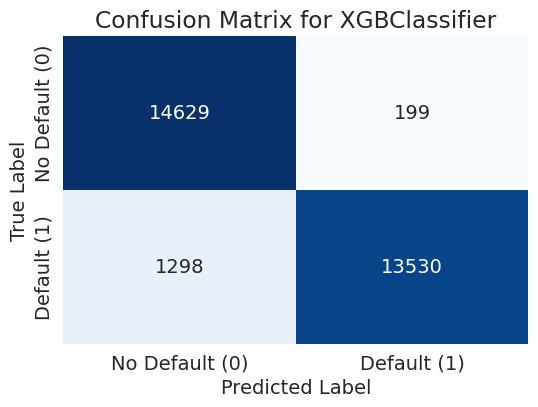


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

  No Default       0.92      0.99      0.95     14828
     Default       0.99      0.91      0.95     14828

    accuracy                           0.95     29656
   macro avg       0.95      0.95      0.95     29656
weighted avg       0.95      0.95      0.95     29656

Precision: 0.99, Recall: 0.91, F1 Score: 0.95




In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score


# Define your classifiers (including DecisionTree, RandomForest, and XGBoost)
classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoostClassifier": xgb.XGBClassifier()
}


def plot_confusion_matrix(y_true, y_pred, classifier_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Train the classifiers and evaluate them using confusion matrix, precision, recall, and F1 score
for key, classifier in classifiers.items():
    # Train the model
    classifier.fit(X_resampled_smote.values, y_resampled_smote.values)

    # Perform cross-validation predictions for the confusion matrix and metrics
    y_pred = cross_val_predict(classifier, X_resampled_smote.values,y_resampled_smote.values, cv=5)

    # Calculate the training score (cross-validation accuracy)
    training_score = cross_val_score(classifier, X_resampled_smote.values,y_resampled_smote.values, cv=5)
    print(f"Classifier: {classifier.__class__.__name__} has a training score of {round(training_score.mean() * 100, 2)}% accuracy\n")

    # Plot the confusion matrix using Seaborn
    plot_confusion_matrix(y_resampled_smote.values, y_pred, classifier.__class__.__name__)

    # Classification report: includes precision, recall, F1-score, and support
    print(f"\nClassification Report for {classifier.__class__.__name__}:")
    print(classification_report(y_resampled_smote.values, y_pred, target_names=['No Default', 'Default']))

    # Print precision, recall, and F1-score for the Default (1) class
    precision = precision_score(y_resampled_smote.values, y_pred)
    recall = recall_score(y_resampled_smote.values, y_pred)
    f1 = f1_score(y_resampled_smote.values, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("\n" + "="*50 + "\n")


In [ ]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

classifiers_param_grids = {
    "DecisionTreeClassifier": (DecisionTreeClassifier(), param_grid_dt),
    "RandomForestClassifier": (RandomForestClassifier(), param_grid_rf),
    "XGBoostClassifier": (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Loop through each classifier and run GridSearchCV
for classifier_name, (classifier, param_grid) in classifiers_param_grids.items():
    print(f"Performing Grid Search for {classifier_name}...")

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_resampled_smote.values, y_resampled_smote.values)

    # Print the best parameters and the best score
    print(f"Best parameters for {classifier_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {classifier_name}: {round(grid_search.best_score_ * 100, 2)}%\n")



Performing Grid Search for DecisionTreeClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Best cross-validation score for DecisionTreeClassifier: 89.86%

Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for RandomForestClassifier: 94.55%

Performing Grid Search for XGBoostClassifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoostClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score for XGBoostClassifier: 95.34%



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[3784 1158]
 [ 258 1104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      4942
           1       0.49      0.81      0.61      1362

    accuracy                           0.78      6304
   macro avg       0.71      0.79      0.73      6304
weighted avg       0.84      0.78      0.79      6304

Precision: 0.49, Recall: 0.81, F1 Score: 0.61


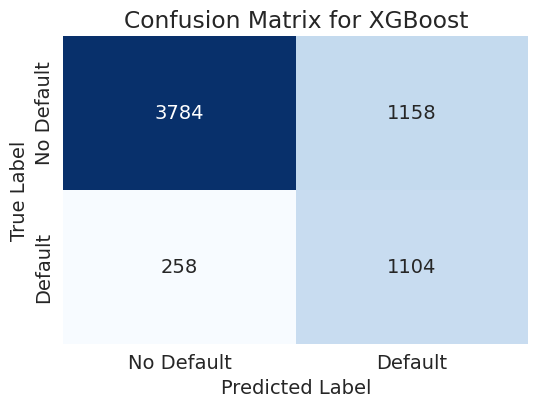

In [ ]:
best_params_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 200,
    'subsample': 0.8,
}

# Initialize XGBoost with the best parameters
xgb_model_2 = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data (if you haven't done this already)
xgb_model_2.fit(X_resampled_smote.values, y_resampled_smote.values)

# Predict on the validation data
y_val_pred = xgb_model_2.predict(X_transformed_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val.values, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val.values, y_val_pred))

# Calculate precision, recall, and F1 score
precision = precision_score(y_val.values, y_val_pred)
recall = recall_score(y_val.values, y_val_pred)
f1 = f1_score(y_val.values, y_val_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    plt.title("Confusion Matrix for XGBoost")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix)


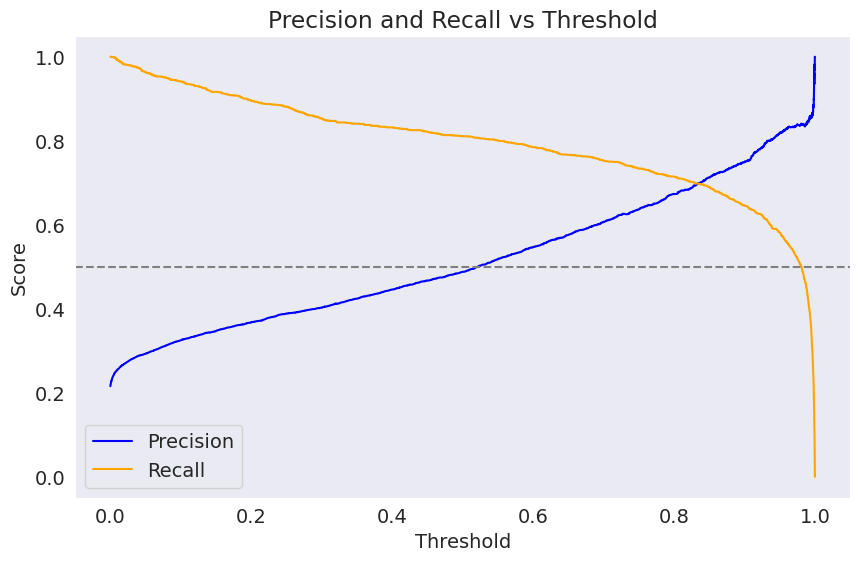

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = xgb_model_2.predict_proba(X_transformed_val)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')
plt.grid()
plt.axhline(y=0.5, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0.5 for reference
plt.show()